## Data base with signals from motion sensors in the smartphone

- using raw data from motion sensors in smartphone (Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set - UCI)

- an experiment carried out on 30 people (19-49 years)

- six activities noticed: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING and postural transtions

- capturing 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz

- 128 readings per window for one signal sample (50% overlap)

- dataset including raw 3-axial data from sensors and labels for each activity:

1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

# Uploading the data from database files
- each signal for each experiment number is saved into separated file, signals from accelerometer and gyroscope are also separated 

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
#Sorting file names in the data folder
file_names = sorted(glob.glob('RawData/*'))

In [3]:
# Making a raw data dictionary for each experiment
raw_dic = {}
# Getting data from 61 experiments
for n in range(61):
    
    # Keys: expXX_userYY where XX number of experiment and YY user's ID
    key = file_names[n][12:24]
    
    # DataFrames with the total accelerometer and gyroscope signals
    raw_acc = pd.read_csv(file_names[n], sep = ' ', header = None, names = ['total_acc_x','total_acc_y','total_acc_z'])
    raw_gyr = pd.read_csv(file_names[n+61], sep = ' ', header = None, names = ['gyro_x','gyro_y','gyro_z'])
    
    # Dictionary with both DataFrames
    raw_dic[key] = pd.concat([raw_acc,raw_gyr],axis = 1)

In [4]:
# Example of the raw DataFrame
raw_dic['exp01_user01'].head(3)

,total_acc_x,total_acc_y,total_acc_z,gyro_x,gyro_y,gyro_z
0,0.918056,-0.112500,0.509722,-0.054978,-0.069639,-0.030849
1,0.911111,-0.093056,0.537500,-0.012523,0.019242,-0.038485
2,0.881944,-0.086111,0.513889,-0.023518,0.276417,0.006414


In [5]:
# DataFrame with database labels
labels = pd.read_csv('RawData/labels.txt', sep=' ', header = None, names = ['Exp_ID','Us_ID','Act_ID','Start_Point','End_Point'] )

In [6]:
# Info about labels DataFrame
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Exp_ID       1214 non-null   int64
 1   Us_ID        1214 non-null   int64
 2   Act_ID       1214 non-null   int64
 3   Start_Point  1214 non-null   int64
 4   End_Point    1214 non-null   int64
dtypes: int64(5)
memory usage: 47.5 KB


In [7]:
labels.head(3)

,Exp_ID,Us_ID,Act_ID,Start_Point,End_Point
0,1,1,5,250,1232
1,1,1,7,1233,1392
2,1,1,4,1393,2194


# Raw Signal Visualisation

In [180]:
# Sampling frequency in this database is 50 Hz 
fs = 50 #Hz

# Function: visualisation all signal for one experiment
def all_data_visual (dataframe, sig):
   
    # Time list where sampling freq = 50 Hz 
    time = [1/(fs) * t for t in range(len(dataframe))]
    if sig == 'acc':
        # ALL Accelerometer signals (X, Y, Z) visualisation
        fig = plt.figure(figsize=(15,5))
        plt.plot(time,dataframe['total_acc_x'],color = 'r', label= 'acc_x', alpha=0.7)
        plt.plot(time,dataframe['total_acc_y'],color = 'b', label= 'acc_y', alpha=0.7)
        plt.plot(time,dataframe['total_acc_z'],color = 'g', label= 'acc_z', alpha=0.7)
        plt.title('Acceleration Signals', fontsize=20)
        plt.xlabel('Time [s]',fontsize=17)
        plt.ylabel('Acceleration [1g]',fontsize=17)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(color='grey', linestyle='--', linewidth=0.2)
    elif sig == 'gyr':
        # ALL Gyroscope signals (X, Y, Z) visualisation
        fig = plt.figure(figsize=(15,5))
        plt.plot(time,dataframe['gyro_x'],color = 'r', label= 'gyr_x', alpha=0.9)
        plt.plot(time,dataframe['gyro_y'],color = 'b', label= 'gyr_y', alpha=0.9)
        plt.plot(time,dataframe['gyro_z'],color = 'g', label= 'gyr_z', alpha=0.9)
        plt.title('Gyroscope Signals',fontsize=20)
        plt.xlabel('Time [s]',fontsize=17)
        plt.ylabel('Angular Velocity [rad/s]',fontsize=17)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(color='grey', linestyle='--', linewidth=0.2)
    else:
        print("Wrong command. Please use: 'acc' or 'gyr'")

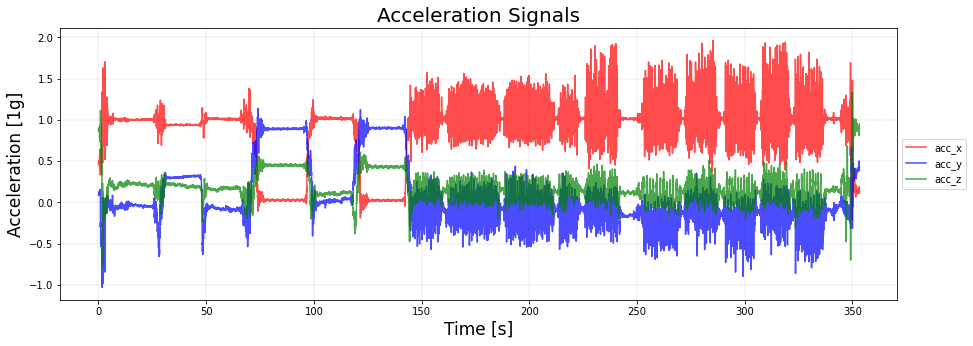

In [196]:
all_data_visual(raw_dic['exp07_user04'],'acc')

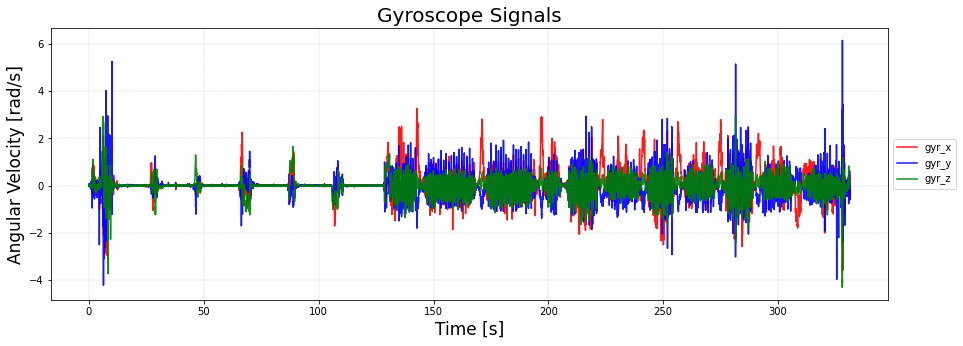

In [197]:
all_data_visual(raw_dic['exp04_user02'],'gyr')

# Signal filtering
- noise reduction
- separating body compontent (without gravity results) from the total accelerometers signals

In [93]:
# Import functions from scipy.signal
from scipy.signal import medfilt, butter, filtfilt

In [198]:
# Function for visualisation the signal to check filtering
def vizualization(signal,title):
    
    # Counting a time from the number of samples (fs = 50 Hz)
    time = [1/(fs) * t for t in range(len(signal))]
    # Drawing a plot
    fig = plt.figure(figsize=(15,5))
    plt.plot(time,signal)
    plt.title(title, fontsize=20)
    plt.xlabel('Time [s]', fontsize=17)
    plt.ylabel('Signal value', fontsize=17)
    plt.grid(color='grey', linestyle='--', linewidth=0.2)

In [199]:
# Function with 3rd order low-pass Butterworth filter (cutoff = 20Hz - cut-off freq.) to reduce the noise either
fs = 50 # Sampling frequency
cutoff= 20  # Cut-off frequency of the filter
W = cutoff/(fs/2) # Normalizing the frequency
def butterworth3rd(m_singal):
    
    # Preparing the low-pass filter
    b, a = butter(3, W, 'low')
    # Using a filter on the signal 
    output = filtfilt(b, a, m_singal)
    # Reutrning filtered signal
    return output

In [200]:
# Using the 3rd order Butterworth filter for a sample of data
butter_signal = butterworth3rd(raw_dic['exp01_user01']['total_acc_x'])

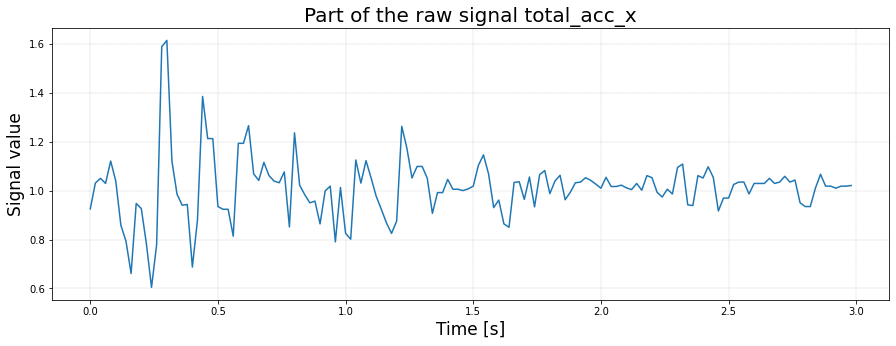

In [201]:
vizualization(raw_dic['exp01_user01']['total_acc_x'][100:250],'Part of the raw signal total_acc_x')

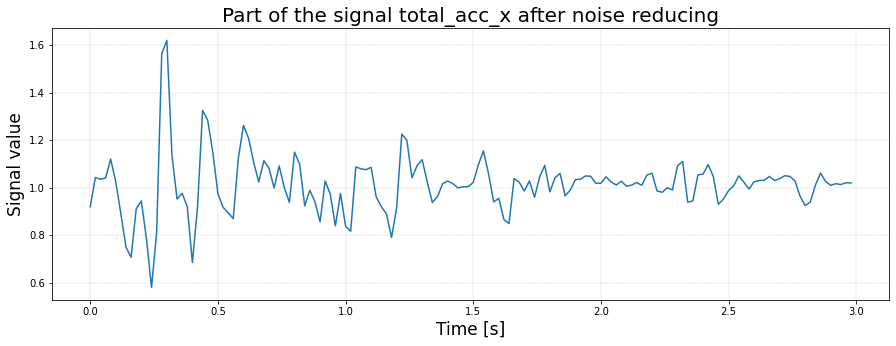

In [202]:
vizualization(butter_signal[100:250],'Part of the signal total_acc_x after noise reducing')

In [213]:
# Import functions for FFT and iFFT
from scipy.fftpack import fft, fftfreq, ifft
import math

# Function with the filter to separate the signal into body and gravity component
def gravity_filter(signal):
    
    # Changing the signal data into the array
    arr_signal = np.array(signal)
    # Using FFT to convert the time singal into the freqency signal
    f_signal = fft(arr_signal)
    # Generating frequencies where the sampling frequency is 50 Hz
    freq = fftfreq(len(arr_signal), d = 1/fs)
    # Copying all frequency signal to gravity and body arrays
    f_grav_signal = f_signal.copy()
    f_body_signal = f_signal.copy()
    # Put null when the signal frequency is above the 0.3 Hz - gravity component
    f_grav_signal[(abs(freq) > 0.3)] = 0
    # Put null when the signal frequency is under the 0.3 Hz - body component
    f_body_signal[(abs(freq) <= 0.3)] = 0
    
    # iFFT to receive real time signals after the filtering
    t_grav_signal = ifft(f_grav_signal).real
    t_body_signal = ifft(f_body_signal).real
    #Returning body and gravity compontents
    return t_body_signal, t_grav_signal

In [214]:
# Using a filter to separate body and gravity components from accelerometers signals
body, grav = gravity_filter(butter_signal)

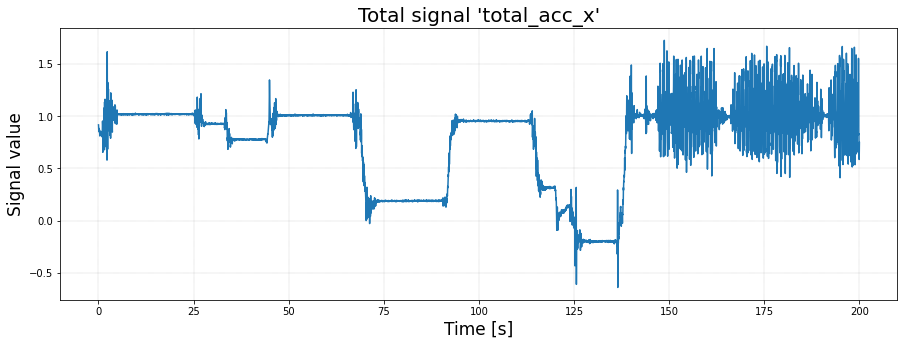

In [203]:
vizualization(butter_signal[:10000],"Total signal 'total_acc_x'")

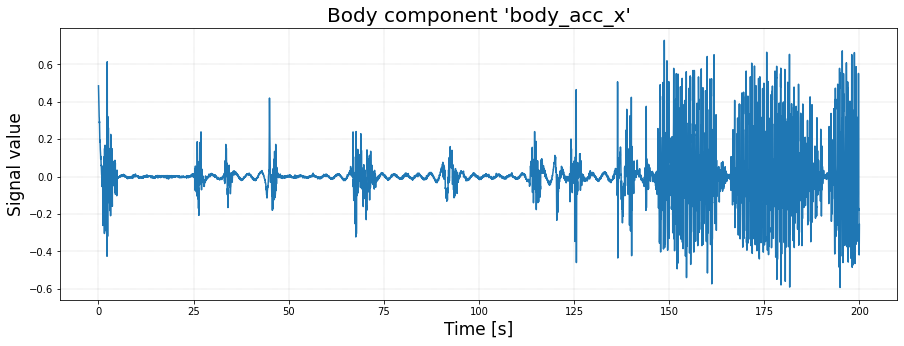

In [204]:
vizualization(body[:10000],"Body component 'body_acc_x'")

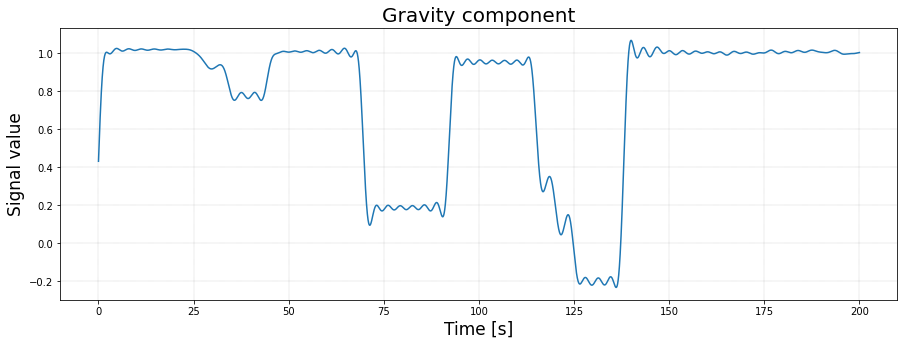

In [205]:
vizualization(grav[:10000],"Gravity component")

In [215]:
# Function to preprocessing all filtered compontents of acceleration and gryoscope signals
def signal_processing(data):
    
    # DataFrame for collecting all informations from signals
    data_df = pd.DataFrame()
   
    # Processing first 3 columns from the raw database containing acc signals
    for label in data.columns[0:3]:
        # Using all designed filters
        butt_sig = butterworth3rd(data[label])
        body, _ = gravity_filter(butt_sig)
        # Saving filtered data into data_df
        data_df['total_acc_'+label[-1]] = butt_sig # total signal
        data_df['body_acc_'+label[-1]] = body # body component

    # Processing next 3 columns from the raw database containing gyro signals: same algorythms but without gravity component
    for label in data.columns[3:6]:
        butt_sig = butterworth3rd(data[label])
        data_df['gyro_'+label[-1]] = butt_sig # total signal
        
    # Stacking columns 
    columns = ['total_acc_x', 'total_acc_y', 'total_acc_z',
               'body_acc_x', 'body_acc_y', 'body_acc_z', 
               'gyro_x', 'gyro_y', 'gyro_z',]
    
    new_data_df = data_df[columns]
    
    return new_data_df

In [118]:
# Creating the dictionary included dataframes with filtered signals datas for all experiments 
filtered_dic = {}
# Signal preprocessing for each number of the experiment
filtered_dic = {key: signal_processing(raw_dic[key]) for key in raw_dic.keys()}

In [157]:
# Dataframe after filtering visualisation
filtered_dic['exp01_user01'].head(3)

,total_acc_x,total_acc_y,total_acc_z,body_acc_x,body_acc_y,body_acc_z,gyro_x,gyro_y,gyro_z
0,0.918099,-0.112457,0.509769,0.485456,-0.288859,-0.210897,-0.055015,-0.069718,-0.030815
1,0.908861,-0.093465,0.535113,0.464887,-0.263184,-0.179784,-0.012474,0.027823,-0.036008
2,0.885978,-0.085477,0.517788,0.430715,-0.248489,-0.191296,-0.023272,0.262427,0.002367


Receiving 9 features for each experiment file: total and body accelerometer signals, gyroscope signals

# Using fixed-width sliding windows on signals
- windowing process
- each sample: 128 time steps (2,56 s) and 50% overlapping
- analyzing only first six activities without postural transitions

In [137]:
# Describing indexes of activities in the dictionary
act_numbers = {1: 'WALKING',           
2: 'WALKING_UPSTAIRS',  
3: 'WALKING_DOWNSTAIRS',
4: 'SITTING',           
5: 'STANDING',          
6: 'LAYING',            
}

In [138]:
# Windowing signals with a span of 2.56 sec (2.56sec × 50Hz = 128 cycles) and an overlap of 50%.
def signal_windowing(data_dic, labels):
    # Creating a dictionary for each window with a keys: 'expAA_us_BB_act_C_D' where AA - experiment id, BB - user id, 
    # C - activity id, D - window id
    win_dic = {}
    # Using only activities with index 1 - 6, postural transitions are not included
    sorted_labels =np.array(labels[labels['Act_ID'] < 7])
    # Window id, first is 0
    win_id = 0
    # Taking each sample from labels
    for sample in sorted_labels:
        # When id numbers are less then 10, add 0 before 
        if sample[0] < 10:
            key_exp = '0' + str(sample[0])
        else:
            key_exp = str(sample[0])
        if sample[1] < 10:
            key_us = '0' + str(sample[1])
        else:
            key_us = str(sample[1])  
        # Creating keys to use right dataframes for the user and the experiment number
        key = 'exp' + key_exp + '_user' + key_us
        # Start_Point from the sample
        start = sample[3]
        # End_Point
        end = sample[4]
        # Act_ID
        act_id = str(sample[2])
        # Windowing a signal described by the sample (from startpoint to endpoint), where the step is 128/2 = 64
        # bc the overlap is 50%
        for start_point in range(start,end - 127,64):
            # Window size 128 cycles
            end_point = start_point + 127
            # Creating a key for the windows dictionary
            key_win = key + '_act' + act_id + '_' + str(win_id)
            # Windowing the signal data
            win_dic[key_win] = data_dic[key][start_point:end_point + 1]
            # Increasing the window id
            win_id+=1
    # Returning the windowing signal dicionary        
    return win_dic

In [139]:
# Windowing the signal
win_dic = signal_windowing(filtered_dic,labels)

In [140]:
# Checking the shape of  the one sample
win_dic['exp01_user01_act1_100'].shape

(128, 9)

* Each window has 9 components. 

In [141]:
# Filtering the labels data ( focused only on motion activities)
# so activities from 1 to 6

# Function to generate output general data: with numbers of activities ID for each window and each sample in this window
def filter_labels(data):
    # Getting keys from the dictionary with the windowing signal
    keys = data.keys()
    # General dataframe with all act id for each window
    label_df = pd.DataFrame()
    # Dataframe to put ID value for one window
    act_df = pd.DataFrame()
    for key in keys:
        act_df['Act_ID'] = [int(key[16])]
        label_df = pd.concat([label_df,act_df],axis=0, ignore_index=True)
    return label_df

In [142]:
# Filtering labels and saving in the general_labels
general_labels = filter_labels(win_dic)

In [143]:
# Describing labels
general_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10399 entries, 0 to 10398
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Act_ID  10399 non-null  int64
dtypes: int64(1)
memory usage: 81.4 KB


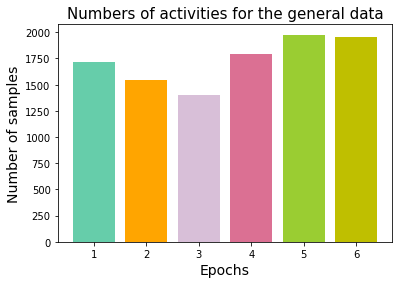

In [210]:
# Visualising the labels dataset
# Histogram for actvities described by the windows with features
# 1 - WALKING
# 2 - WALKING_UPSTAIRS
# 3 - WALKING_DOWNSTAIRS
# 4 - SITTING
# 5 - STANDING
# 6 - LAYING
labels, counts = np.unique(general_labels, return_counts=True)
plt.bar(labels, counts, color=['mediumaquamarine', 'orange', 'thistle', 'palevioletred', 'yellowgreen','y'])
plt.gca().set_xticks(labels)
plt.title('Numbers of activities for the general data', fontsize=15)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Number of samples', fontsize=14)
plt.show()

# Changing the shape of the data to be compatible with a CNN
* preparing the data into the shape [samples, window_shape, components] where:
samples = 10399, window_shape = 128 and components = 9 

In [145]:
samples = len(win_dic) # Number of samples
window_shape = win_dic['exp01_user01_act5_0'].shape[0] # Value of the window shape
components = win_dic['exp01_user01_act5_0'].shape[1] # Number of components

# Keys from the data dictionary
keys = list(win_dic.keys())

In [146]:
print('DATA SHAPE: [' + str(samples) + ', ' + str(window_shape) + ', ' + str(components) + ']' )

DATA SHAPE: [10399, 128, 9]


In [147]:
# Data to save reshaped data from the win_dic with the shape (samples,window_shape,components)
general_data = np.empty(shape = (samples,window_shape,components)) 

In [148]:
for i in range(samples):
    general_data[i] = win_dic[keys[i]].values

In [149]:
# Final shape of the data
general_data.shape

(10399, 128, 9)

# Normalisation
* all values have to be between -1 and 1

In [150]:
# Function to fing global maximum value for one component
def find_max(data, component):
    maximum = 0 # default value
    for i in range(samples):
        for j in range(window_shape):
            if maximum <= data[i][j][component]:
                maximum = data[i][j][component]
    return maximum

In [151]:
# Function to fing global minimum value for one component
def find_min(data, component):
    minimum = 0 # default value
    for i in range(samples):
        for j in range(window_shape):
            if minimum >= data[i][j][component]:
                minimum = data[i][j][component]
    return minimum

In [152]:
# Saving max and min values into dataframes for nine components (0-8)
maximum = pd.DataFrame()
minimum = pd.DataFrame()
for component in range(components):
    maximum[str(component)] = [find_max(general_data,component)]
    minimum[str(component)] = [find_min(general_data,component)]

In [159]:
# Visualisation of the dataframe
maximum

,0,1,2,3,4,5,6,7,8
0,2.09318,1.679395,1.279333,1.215825,1.014024,1.02971,4.239656,6.876592,3.204549


In [160]:
minimum

,0,1,2,3,4,5,6,7,8
0,-0.611752,-1.676159,-1.807025,-1.255404,-1.457404,-1.391085,-5.243325,-5.416154,-2.803811


In [161]:
# Function to normalise values 
# its: 2 * (x - x_min) / (x_max - x_min) - 1
def normalisation(data, maximum, minimum):
    # saving column indexes
    col = maximum.columns
    # initialazing array for the normalised data
    norm_data = np.zeros(shape = (samples, window_shape, components))
    # normalising process
    for i in range(samples):
        for j in range(window_shape):
            for k in range(components):
                norm_data[i][j][k] = 2 * (data[i][j][k] - minimum[col[k]]) / (maximum[col[k]] - minimum[col[k]]) - 1
    # returning normalised data           
    return norm_data    

In [162]:
# Normalisation
norm_data = normalisation(general_data, maximum, minimum)

In [163]:
norm_data.max()

1.0

In [164]:
norm_data.min()

-1.0

* all values are between -1 and 1

# Division of data into training and testing
* 70% training and 30% testing samples

In [165]:
from sklearn.model_selection import train_test_split

In [166]:
# Changing names to show this process more clear
X = norm_data
y = np.array(general_labels)

In [167]:
# Division process 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state = 42)

In [168]:
# Checking the shape 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7279, 128, 9), (7279, 1), (3120, 128, 9), (3120, 1))

Text(0, 0.5, 'Number of samples')

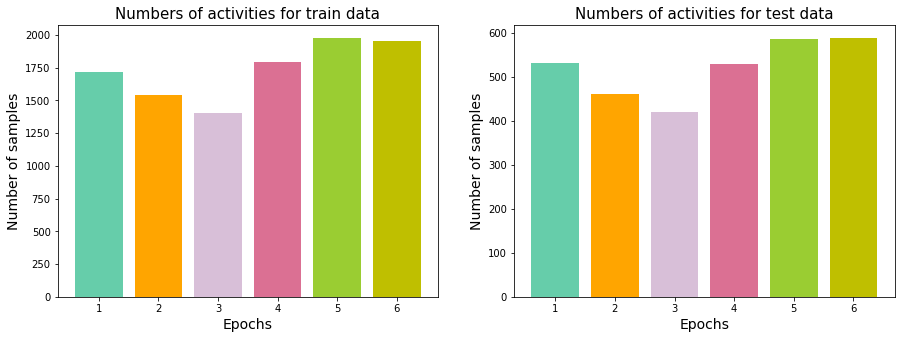

In [212]:
# Visualising the separated dataset
labels1, counts1 = np.unique(y_train, return_counts=True)
labels2, counts2 = np.unique(y_test, return_counts=True)
fig, (axs1, axs2) = plt.subplots(1,2,figsize=(15,5))
axs1.bar(labels, counts, color=['mediumaquamarine', 'orange', 'thistle', 'palevioletred', 'yellowgreen','y'])
axs1.set_title('Numbers of activities for train data',fontsize=15)
axs1.set_xlabel('Epochs', fontsize=14)
axs1.set_ylabel('Number of samples', fontsize=14)
axs2.bar(labels2, counts2, color=['mediumaquamarine', 'orange', 'thistle', 'palevioletred', 'yellowgreen','y'])
axs2.set_title('Numbers of activities for test data',fontsize=15)
axs2.set_xlabel('Epochs', fontsize=14)
axs2.set_ylabel('Number of samples', fontsize=14)

* Train data and test data are balanced together, so function train_test_split is enough to this project
* Getting 7279 samples of the train data and 3120 samples of test data
* Database is ready to use for 

# Saving the data into .txt files

In [170]:
# Reshaping data to save it into .txt file
X_train_rsh = X_train.reshape(X_train.shape[0], -1)
X_test_rsh = X_test.reshape(X_test.shape[0], -1)

In [172]:
#Saving data
np.savetxt('GeneralData/X_train.txt', X_train_rsh)
np.savetxt('GeneralData/X_test.txt', X_test_rsh)
np.savetxt('GeneralData/y_train.txt', y_train)
np.savetxt('GeneralData/y_test.txt', y_test)

* it is necessary to reshape data to the previous shape to use it again